In [1]:
import sys
import os
src_path = os.path.join(os.getcwd(), '..')
sys.path.append(src_path)

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.models import VariationalAutoencoder
from src.train_and_eval import get_default_dataset

In [2]:
ds = get_default_dataset()
vae = VariationalAutoencoder(
    input_shape=(1, 64, 64),
    latent_space_dim=128,
    encoder_conv_channels=(16, 32, 32, 64, 64),
    encoder_conv_kernel_size=(3, 3, 3, 3, 3),
    encoder_conv_stride=(2, 2, 2, 2, 2),
    encoder_conv_padding=(1, 1, 1, 1, 1),
    decoder_conv_t_channels=(64, 32, 16, 16, 1),
    decoder_conv_t_kernel_size=(3, 3, 3, 3, 3),
    decoder_conv_t_stride=(2, 2, 2, 2, 2),
    decoder_conv_t_padding=(1, 1, 1, 1, 1)
)
vae.load_state_dict(torch.load("../train_logs/tr1_eps=0.001_model.pth", weights_only=True))
vae.eval()

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
  )
  (mean_linear): Linear(in_features=256, out_features=128, bias=True)
  (logvar_linear): Linear(in_features=256, out_features=128, bias=True)
  (decoder_linear): Linear(in_features=128, out_features=256, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4)

# Visualize the model's sample method

In [3]:
#Predict the mean and logvar values for some images
#Concatenate the first dim_size dimensions of these tensors and return
def mean_and_logvar(indices, dim_cnt=2):
    means = []
    logvars = []
    for (i, index)in enumerate(indices):
            x = ds[index][0]
            pred, mu, sigma = vae(x.unsqueeze(0))
            means.append(mu[:, :dim_cnt].detach())
            logvars.append(sigma[:, :dim_cnt].detach())

    return torch.concat(means, 0), torch.concat(logvars, 0)

In [4]:
indices = np.random.randint(0, len(ds), 1000)
means, logvars = mean_and_logvar(indices)

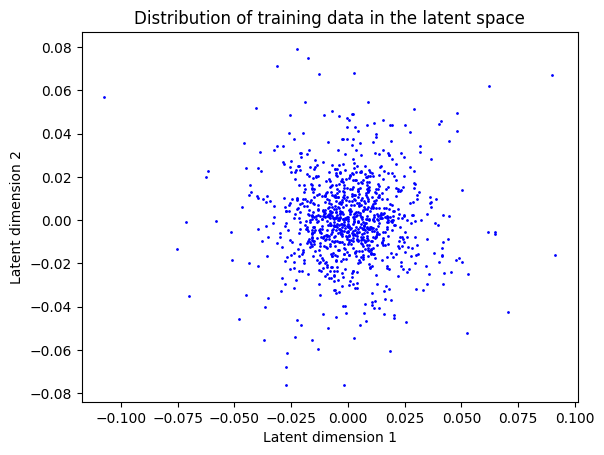

In [5]:
plt.title("Distribution of training data in the latent space")
plt.scatter(
    means[:, 0],
    means[:, 1],
    s = 1.0,
    c='b'
)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.show()

In [6]:
# Get more samples of an image with the model's sample method
def get_samples(index, sample_cnt, eps, dim_cnt=2):
    x = ds[index][0]
    _, mu, sigma = vae(x.unsqueeze(0))
    samples = []
    for i in range(sample_cnt):
        sample = vae.sample(mu, sigma, eps)
        samples.append(sample[:, :dim_cnt].detach())
    return torch.concat(samples, 0)

In [8]:
eps = 0.001
samples = get_samples(indices[100], 100, eps=eps)
samples.shape

torch.Size([100, 2])

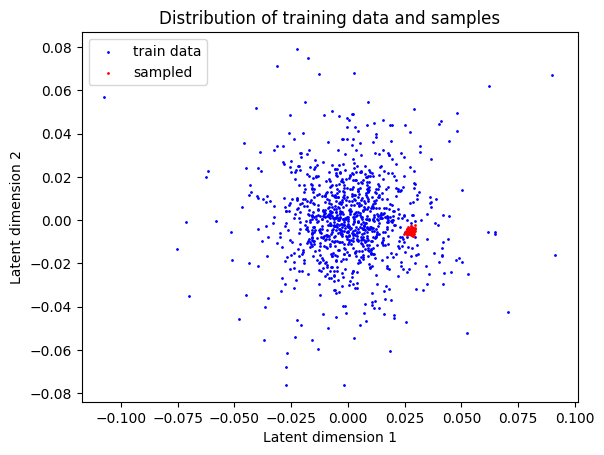

In [9]:
plt.title("Distribution of training data and samples")
plt.scatter(
    means[:, 0],
    means[:, 1],
    s = 1.0,
    c='b'
)
plt.scatter(
    samples[:, 0],
    samples[:, 1],
    s = 1.0,
    c='r'
)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.legend(["train data", "sampled"])
plt.show()